In [3]:
from osgeo import osr, ogr, gdal
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np 
import pandas as pd 
import geopandas as gpd
import rasterio
from sklearn.model_selection import train_test_split
import geopandas as gpd
from rasterio.plot import show
from geohelpers import collocate, getCoords
from osgeo import osr, ogr, gdal
import pyproj
from pyproj import Proj, transform
import geopandas as gpd
import numpy as np
import rasterio
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
import math
import datetime
import geopandas as gpd

ModuleNotFoundError: No module named 'geohelpers'

goal: produce a 30m raster where each pixel is binned by some index (using a dummy rn) Use SVR (support vector regression) for continuous multi-class classification.

In [ ]:
td = r"data\MetroLinkStatinsTEST.shp"

td_gdf = gpd.read_file(td)
td_gdf = td_gdf.drop(columns= ['OBJECTID']) 
td_gdf = td_gdf.drop(columns= ['OBJECTID_1']) 
td_gdf = td_gdf.drop(columns= ['StopName']) 
td_gdf = td_gdf.drop(columns= ['StopAbbr']) 
td_gdf = td_gdf.drop(columns= ['StopID']) 

td_gdf.head()

In [ ]:
import rasterio
import numpy as np

# List of raster file paths
raster_files = [
    r"FeatureMat\CID_bin_fm.tif",
  #  r"FeatureMat\NLNorm_fm.tif",
    r"FeatureMat\OppZones_bin_fm.tif",
  #  r"FeatureMat\parksNormDist_fm.tif",
  #  r"FeatureMat\POP_30m.tif",
  #  r"FeatureMat\Routes_bin_fm.tif",
  #  r"FeatureMat\SBDs_bin_fm.tif",
  #  r"FeatureMat\TDD_bin_fm.tif",
  #  r"FeatureMat\TIF_bin_fm.tif",
  #  r"FeatureMat\trans_weigh.tif"
]

# Initialize an empty list to store the arrays
arrays = []

# Loop through each raster file and read it as an array
for file_path in raster_files:
    with rasterio.open(file_path) as src:
        arr = src.read(1)  # Assuming you want to read the first band (index 0)
        print(arr.shape)
        arrays.append(arr)

# Concatenate the arrays along the third axis (axis=2) to create an nxmx10 array
feature_mat = np.stack(arrays, axis=2)

# Print information about the concatenated array
print("Shape of the concatenated array:", feature_mat.shape)
print("Data type of the concatenated array:", feature_mat.dtype)
print("Mean value of the concatenated array:", np.mean(feature_mat))


#n rows, m columns, h bands
n, m, h = feature_mat.shape
print('m: ',m,'n: ',n,'h: ',h)

In [ ]:
def transform_4326_to_3857(lat, long):
    # make spatial references
    # 4326 in
    InSR = osr.SpatialReference()
    InSR.ImportFromEPSG(4326)
    # 3857 out
    OutSR = osr.SpatialReference()
    OutSR.ImportFromEPSG(3857)
    
    # create the point
    Point = ogr.Geometry(ogr.wkbPoint)
    Point.AddPoint(lat,long)

    # assign the spacial reference to the point
    Point.AssignSpatialReference(InSR)

    # transform
    transform_error_code = Point.TransformTo(OutSR)

    # error check (eg, point is out of bounds, etc)
    if transform_error_code == 0:
        # success
        return (Point.GetX(),Point.GetY())
    else:
        #failed
        logging.warn("Transform failed! Error {transform_error_code}")
        return None

In [ ]:
td_label = [td_gdf['trans_weig']]
tdd = [td_gdf['TDD_bin_fm']]
routes = [td_gdf['Routes_bin']]
cid = [td_gdf['CID_bin_fm']]
opp = [td_gdf['OppZones_b']]
tif = [td_gdf['TIF_bin_fm']]
sbd = [td_gdf['SBDs_bin_f']]
nl = [td_gdf['NLNorm_fm']]
parks = [td_gdf['parksNormD']]
pop = [td_gdf['StlPop_fm']]
lon_list = [td_gdf['LON']]
lat_list = [td_gdf['LAT']]

In [ ]:
'''
td_df = df = pd.DataFrame({
    'Lon': lon_list,
    'Lat': lat_list,
    'index': td_label,
})
'''
lon_d = pd.DataFrame(lon_list).T
lat_d = pd.DataFrame(lat_list).T
label_d = pd.DataFrame(td_label).T
tdd_d = pd.DataFrame(tdd).T
routes_d = pd.DataFrame(routes).T
cid_d = pd.DataFrame(cid).T
opp_d = pd.DataFrame(opp).T
tif_d = pd.DataFrame(tif).T
sbd_d = pd.DataFrame(sbd).T
nl_d = pd.DataFrame(nl).T
parks_d = pd.DataFrame(parks).T
pop_d = pd.DataFrame(pop).T

td_df = pd.concat([lon_d, lat_d, label_d, tdd_d, routes_d, cid_d, opp_d, tif_d, sbd_d, nl_d, parks_d, pop_d], axis=1)


In [ ]:
td_df.head()

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
#prepare class label array!
n_samples, n_features = td_df.shape[0], td_df.shape[1]-2
X = np.array(td_df.iloc[:,2:4]) #train model on everything but lat and lon
y = td_df.iloc[:,2] #class labels

In [ ]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X, y)

In [ ]:
'''
y_pred = regr.predict(X_test)
print(y_pred)
y_pred_2 = clf.predict(X_train)
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Training Accuracy:",metrics.accuracy_score(y_train, y_pred_2))
'''

In [ ]:
print('m: ',m,'n: ',n,'h: ',h)
hi = feature_mat.reshape(h, m*n)
v = pd.DataFrame(hi)
'''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
display(v)
'''

In [ ]:
import time
start_time = time.time()  # Start timing

assignments = []
for col in v:
    if not pd.isna(v.iloc[0,col]):  # Check if the value is not NaN
        print('row: ', v.loc[:,col])
        class_pred = regr.predict(np.array(v.loc[:, col]).reshape(1, -1))[0]
        #print(class_pred)
    else:
        class_pred = 'NaN'
       #print(class_pred)
    if col%1000 == 0:
        print('px: ', col, ' assignment: ', class_pred)
    assignments.append(class_pred)
print("Done")

In [21]:
print('time taken to run the program: ', total_time//60, ' minutes')

time taken to run the program:  1.0  minutes


In [23]:
assignmentsArr = np.array(assignments)
print(assignmentsArr.shape)
lc = assignmentsArr.reshape(m,n)
print(lc.shape)

(50880,)
(159, 320)


AttributeError: module 'matplotlib.pyplot' has no attribute 'aspect'

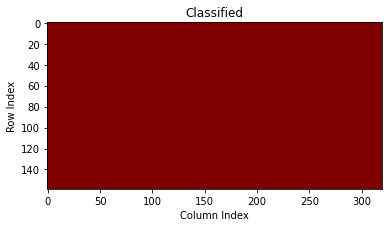

In [27]:
# Plot Classified Image 
img_class = plt.imshow(lc, cmap='jet_r')
plt.title('Classified')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

plt.show()

In [ ]:
#function to write array to tiff
def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)  # Create a 2D image
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    out_ds.GetRasterBand(1).WriteArray(arr)  # Write the 2D image data to the GeoTIFF
    out_ds.FlushCache()
    out_ds = None  # Close the dataset to save changes

In [ ]:
#function to 
write_geotiff("data\LandCoverStl.tif", lc, ndvi_ds)   
